# Importing Data and Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error  
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

In [2]:
# importing train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# EDA

In [3]:
train.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [4]:
train.shape

(300, 6)

In [5]:
train.describe()

,id,Open,Close,Volume
count,300.000000,300.000000,300.000000,3.000000e+02
mean,149.500000,75.977813,79.430489,1.866300e+08
std,86.746758,16.158343,13.878395,7.952792e+07
min,0.000000,40.269435,47.979353,5.991330e+07
25%,74.750000,64.872395,69.689227,1.324862e+08
50%,149.500000,79.805683,82.991900,1.715536e+08
75%,224.250000,88.342927,89.719145,2.201842e+08
max,299.000000,102.558322,103.119373,6.935702e+08


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Date      300 non-null    object 
 2   Open      300 non-null    float64
 3   Close     300 non-null    float64
 4   Volume    300 non-null    int64  
 5   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.2+ KB


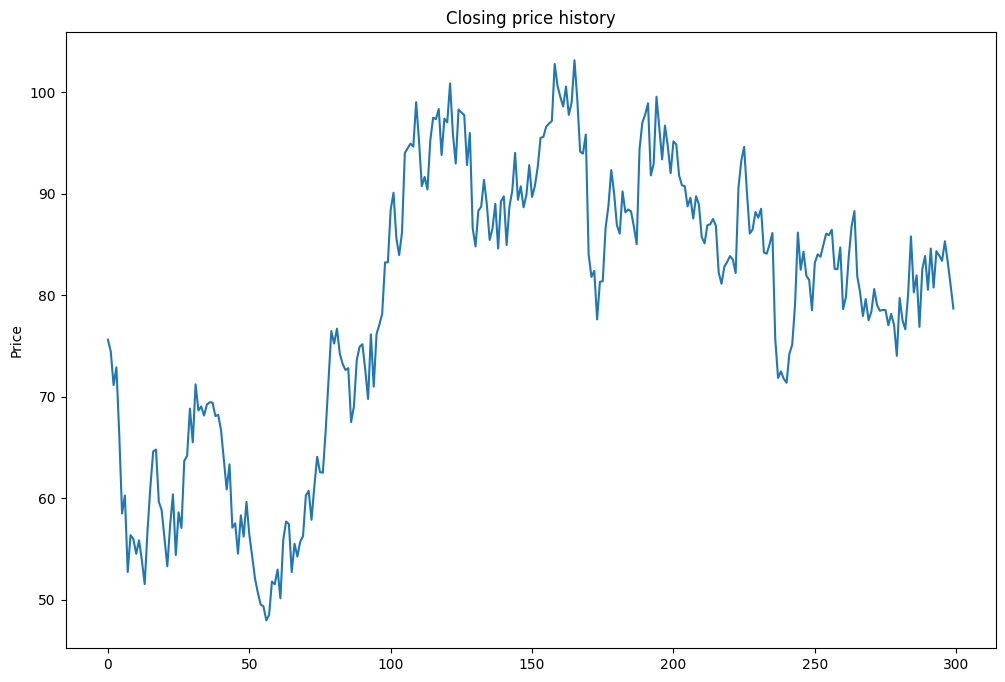

In [7]:
plt.figure(figsize=(12,8))
plt.plot(train['Close'])
plt.title('Closing price history')
plt.ylabel('Price')
plt.show()

In [8]:
train.isnull().sum()

id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\514670500.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col])
C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\514670500.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[col])
C:\Users\Aaryan Shetty\AppData\L

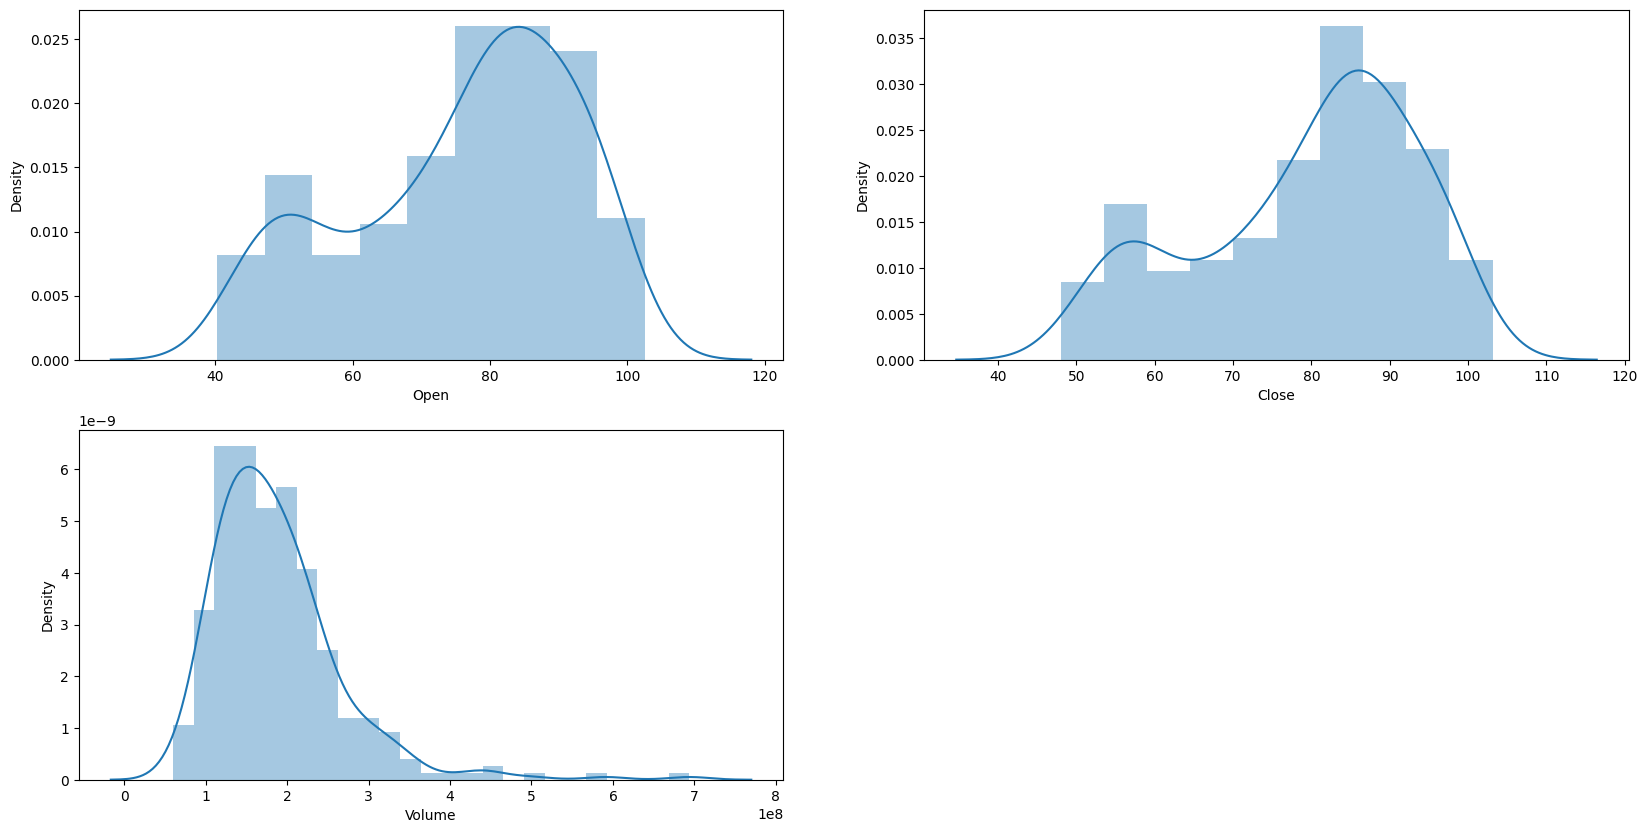

In [9]:
features = train[['Open', 'Close', 'Volume']]

plt.figure(figsize=(20, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.distplot(train[col])

plt.show()

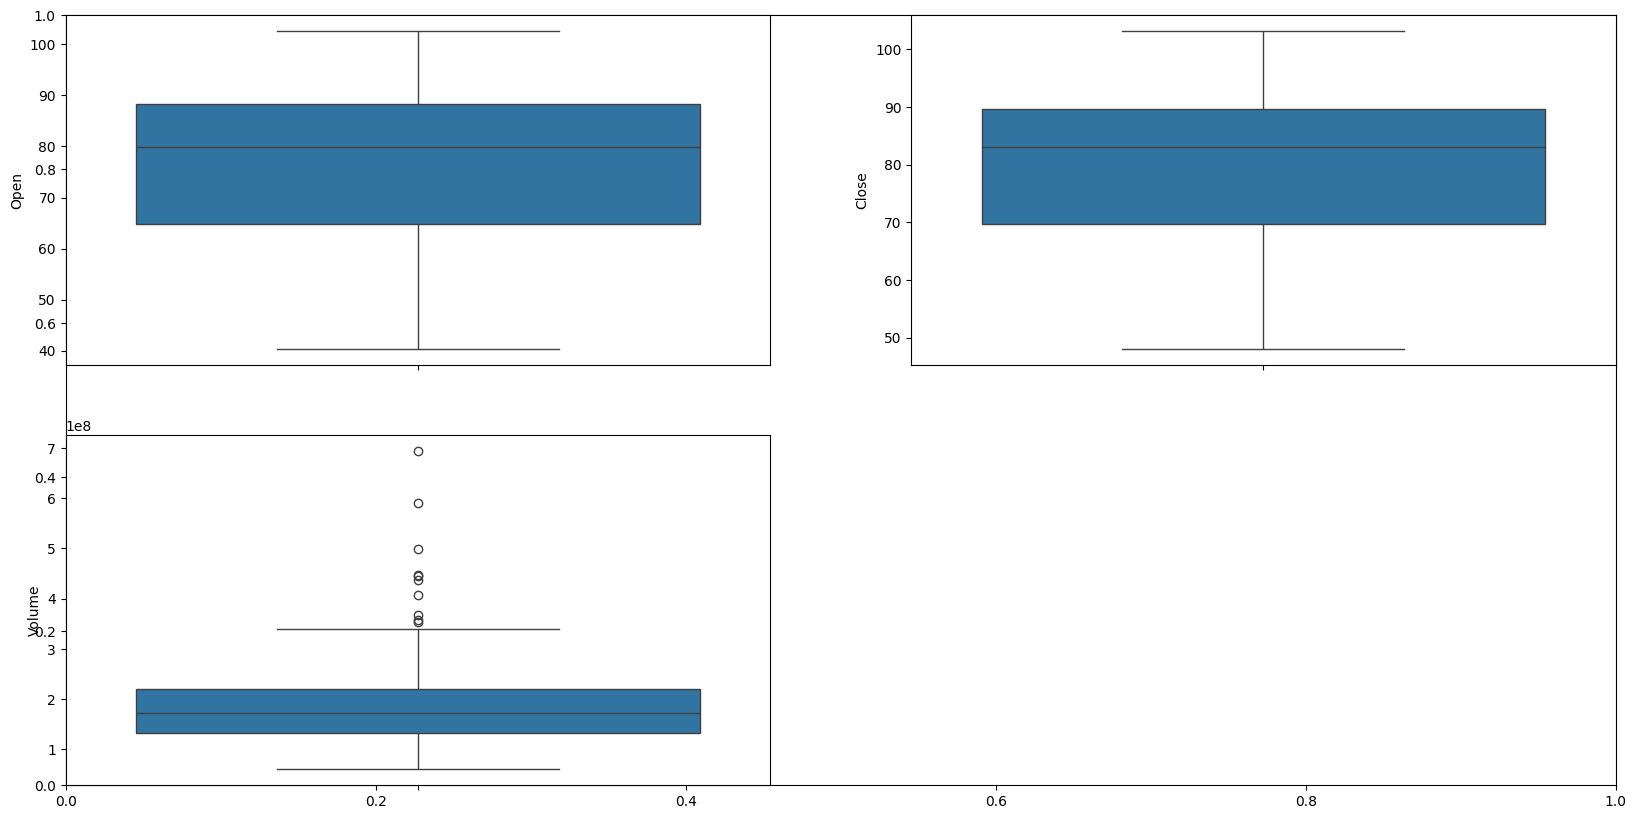

In [10]:
plt.subplots(figsize=(20, 10))

for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(train[col])

plt.show()

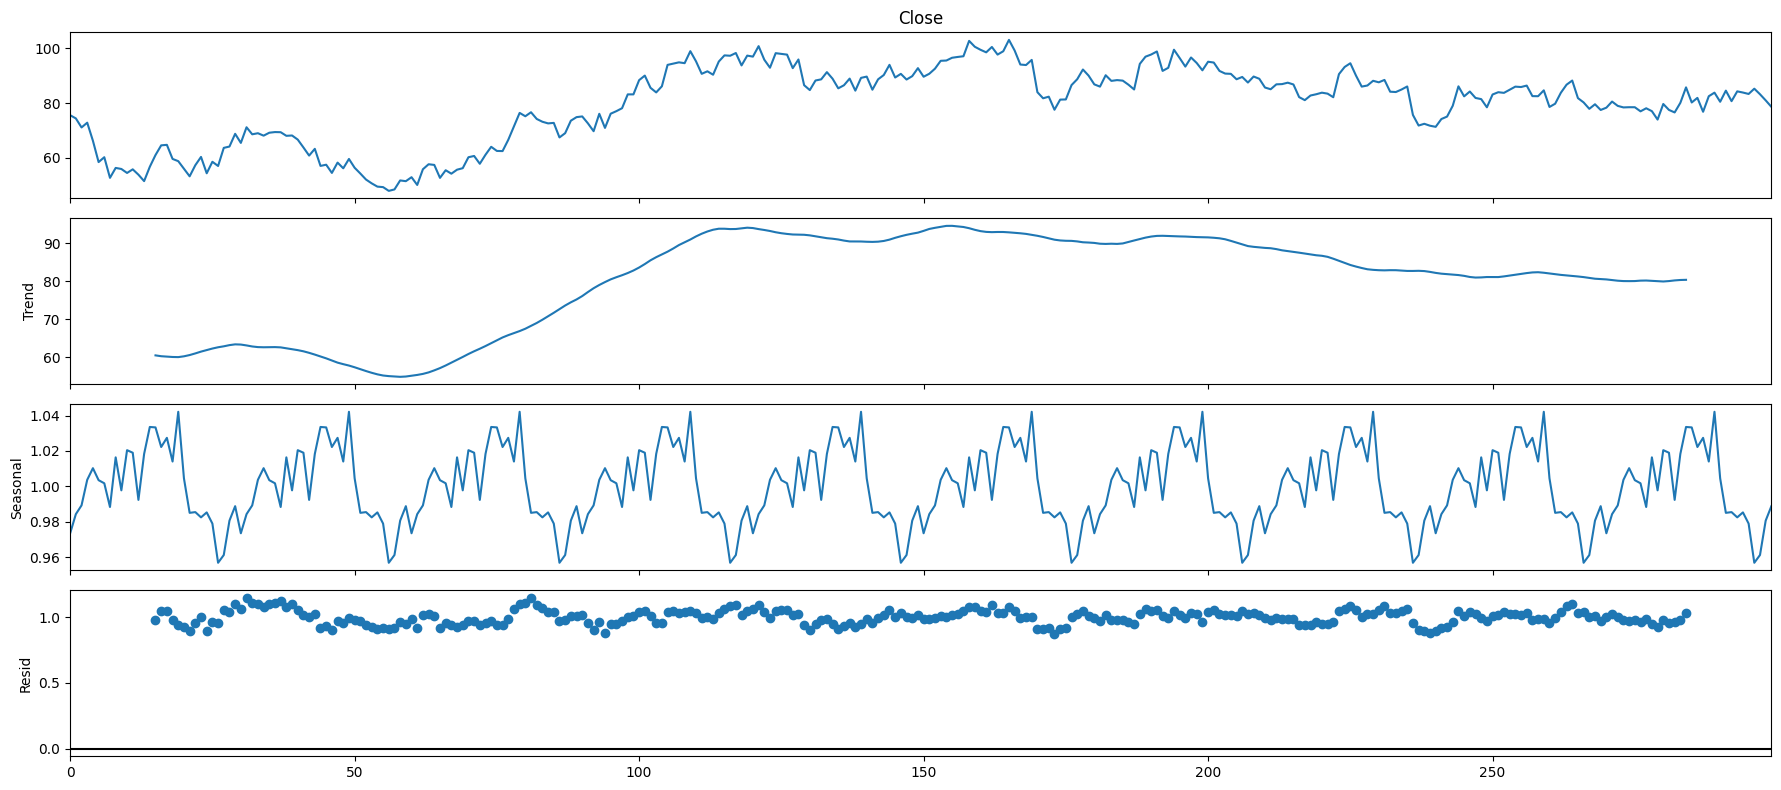

In [11]:
# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(train['Close'], model='multiplicative', period=30)
fig = decomposition.plot()
plt.show()

## Feature Engineering

In [12]:
# open lag of 1
train['Open_lag1'] = train['Open'].shift(1)
test['Open_lag1'] = test['Open'].shift(1)

# open_diff of 1
train['Open_diff1'] = train['Open'].diff(1)
test['Open_diff1'] = test['Open'].diff(1)

# open_volume
train['Open_volume'] = train['Open'] * train['Volume']
test['Open_volume'] = test['Open'] * test['Volume']

train = train.fillna(method='bfill')
test = test.fillna(method='bfill')


C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\1499886501.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.fillna(method='bfill')
C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\1499886501.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test = test.fillna(method='bfill')


In [13]:
features = ['Open', 'Volume', 'Open_volume']
train[features].head()

,Open,Volume,Open_volume
0,66.208486,298506300,1.976365e+10
1,64.116235,227974800,1.461689e+10
2,47.701942,250670900,1.195749e+10
3,54.754816,223614300,1.224396e+10
4,48.031899,406814900,1.954009e+10


In [14]:
endogenous = train['Close']
exogenous = train[features]

## THE SARIMAX MODEL

In [15]:
# build the model using the entire train data and predict the test data

model = SARIMAX(endog=endogenous, exog=exogenous, order=(1,0,1), seasonal_order=(5,0,1,4), trend='c')
model_fit = model.fit(disp=False)

y_pred = model_fit.predict(start=len(endogenous), end=len(endogenous)+len(test)-1, exog=test[features])

print(y_pred)

test['Close'] = y_pred.reset_index().predicted_mean

print(test.head())

# save the predictions to a csv file
test.to_csv('data/sarimax_test.csv', index=True, index_label='id', columns=['Date', 'Open', 'Volume', 'Close'])

300    77.655908
301    76.967702
302    74.248696
303    74.567516
304    72.259006
         ...    
395    63.467079
396    65.859426
397    66.616427
398    61.421625
399    62.929633
Name: predicted_mean, Length: 100, dtype: float64
   id        Date       Open     Volume  Open_lag1  Open_diff1   Open_volume  \
0   0  2021-03-01  72.708331  205897600  72.708331    0.602555  1.497047e+10   
1   1  2021-03-08  73.310886  214095600  72.708331    0.602555  1.569554e+10   
2   2  2021-03-15  70.610119  151601700  73.310886   -2.700767  1.070461e+10   
3   3  2021-03-22  70.256017  193982500  70.610119   -0.354102  1.362844e+10   
4   4  2021-03-29  68.258324  220238400  70.256017   -1.997693  1.503310e+10   

       Close  
0  77.655908  
1  76.967702  
2  74.248696  
3  74.567516  
4  72.259006  


C:\Users\Aaryan Shetty\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Classification Model

In [16]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
# Define and train your base models (XGBoost and RandomForest)
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()

In [18]:
# load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/sarimax_test.csv')

In [19]:
def rsi(df, n):
    delta = df.diff()
    delta = delta[1:]
    up, down = delta.copy(), delta.copy()
    up[up<0] = 0
    down[down>0] = 0
    roll_up = up.rolling(window=n).mean()
    roll_down = down.rolling(window=n).mean().abs()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def macd(df, n_fast, n_slow):
    EMAfast = df['Close'].ewm(span=n_fast, min_periods=n_slow).mean()
    EMAslow = df['Close'].ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = EMAfast - EMAslow
    signal = MACD.ewm(span=9, min_periods=9).mean()
    return MACD, signal

def ROC(data,n):
    N=data['Close'].diff(n)
    D=data['Close'].shift(n)
    ROC=pd.Series(N/D,name='Rate of Change')
    #print('In function')
    #print()
    return ROC

def CCI(data, ndays):
    TP = (data['High'] + data['Low'] + data['Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(ndays).mean()) / (0.015 * TP.rolling(ndays).std()),
    name = 'CCI') 
    return CCI

def bbands(df, n):
    MA = df['Close'].rolling(window=n).mean()
    SD = df['Close'].rolling(window=n).std()
    up = MA + (2 * SD)
    low = MA - (2 * SD)
    return MA, up, low


In [20]:
train['SMAC'] = train['Close'].rolling(window=10).mean()
train['SMAC_50'] = train['Close'].rolling(window=50).mean()
train['EMA'] = train['Close'].ewm(span=10, adjust=True).mean()
train['RSI'] = rsi(train['Close'], 16)
train['MACD'], train['Signal'] = macd(train, 18, 9)
train['Close_lag_1'] = train['Close'].shift(1)
train['Open_lag_1'] = train['Open'].shift(1)
train['ROC'] = ROC(train, 4)
train['MA'], train['Upper'], train['Lower'] = bbands(train, 12)

test['SMAC'] = test['Close'].rolling(window=10).mean()
test['SMAC_50'] = test['Close'].rolling(window=50).mean()
test['EMA'] = test['Close'].ewm(span=10, adjust=True).mean()
test['RSI'] = rsi(test['Close'], 16)
test['MACD'], test['Signal'] = macd(test, 18, 9)
test['Close_lag_1'] = test['Close'].shift(1)
test['Open_lag_1'] = test['Open'].shift(1)
test['ROC'] = ROC(test, 4)
test['MA'], test['Upper'], test['Lower'] = bbands(test, 12)

features = ['Open', 'SMAC_50', 'RSI', 'SMAC', 'MA', 'Upper', 'Lower', 'Volume', 'EMA', 'ROC', 'Signal', 'MACD']

# backfill missing values
train[features] = train[features].fillna(method='bfill', axis=0)
test[features] = test[features].fillna(method='bfill', axis=0)


C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\2981981840.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[features] = train[features].fillna(method='bfill', axis=0)
C:\Users\Aaryan Shetty\AppData\Local\Temp\ipykernel_59912\2981981840.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test[features] = test[features].fillna(method='bfill', axis=0)


In [21]:
# normalize data
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
stored_close = test['Close']
test[features] = scaler.transform(test[features])


In [22]:
X = train[features]
y = train['Strategy']

# map strategy to 0, 1 and 2 for Hold, Buy and Sell respectively
y = y.map({'Hold': 0, 'Buy': 1, 'Sell': 2})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Generate predictions from the base models
xgb_predictions = xgb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# Create a meta-model (e.g., another XGBoost model) to combine base model predictions
# meta_model = XGBClassifier()
meta_model = RandomForestClassifier()
meta_model.fit(np.column_stack((xgb_predictions, rf_predictions)), y_test)


RandomForestClassifier()

In [23]:
# Train the meta-model on the predictions of the base models
meta_model.fit(np.column_stack((xgb_predictions, rf_predictions)), y_test)

RandomForestClassifier()

In [24]:
# train on full data
xgb_model.fit(X, y)
rf_model.fit(X, y)

# now predict on test data
xgb_predictions = xgb_model.predict(test[features])
rf_predictions = rf_model.predict(test[features])
meta_model_predictions = meta_model.predict(np.column_stack((xgb_predictions, rf_predictions)))


In [25]:
print('XGBoost predictions: ', xgb_predictions)
print('Random Forest predictions: ', rf_predictions)
print('Meta-model predictions: ', meta_model_predictions)


XGBoost predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 2 2 2 2 2 0 2 0 0 2 2 2 2 2 2
 2 2 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 2 2 2 2 2 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1]
Random Forest predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 2 2 2 2 2 0 2 0 0 2 2 2 2 2 0
 2 2 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 2 2 2 2 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1]
Meta-model predictions:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 2 2 2 2 2 0 2 0 0 2 2 2 2 2 0
 2 2 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 2 2 2 2 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1]


In [26]:
test['Strategy'] = meta_model_predictions

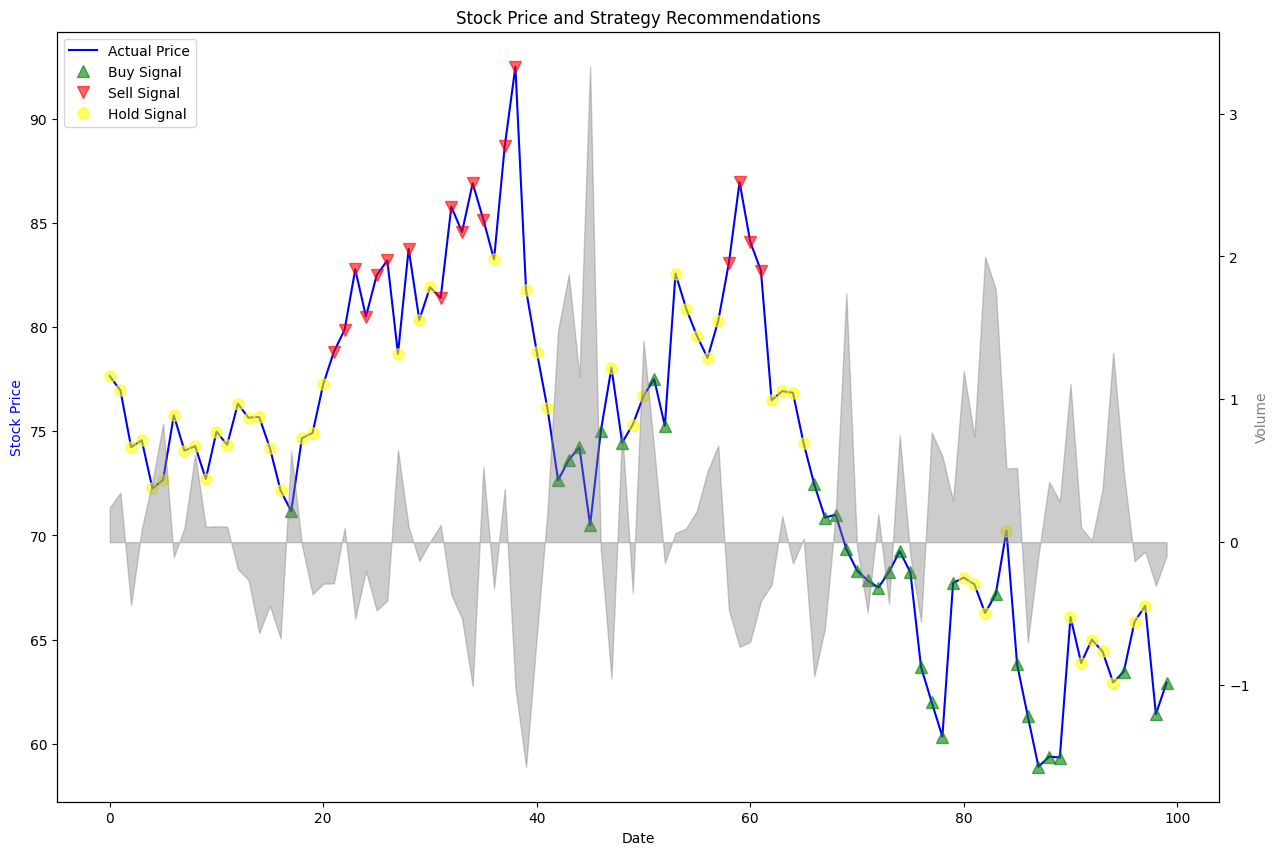

In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 10))

test['Close'] = stored_close

# Plot the stock price and strategy signals on the primary y-axis
ax1.plot(test['Close'], label='Actual Price', color='blue')
# ax1.plot(test['Open'], label = 'Open', color = 'green')
ax1.plot(test['Close'].where(test['Strategy'] == 1), marker='^', markersize=8, color='green', label='Buy Signal', linestyle='', alpha=0.6)
ax1.plot(test['Close'].where(test['Strategy'] == 2), marker='v', markersize=8, color='red', label='Sell Signal', linestyle='', alpha=0.6)
ax1.plot(test['Close'].where(test['Strategy'] == 0), marker='o', markersize=8, color='yellow', label='Hold Signal', linestyle='', alpha=0.6)
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='blue')
ax1.legend(loc='upper left')

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.fill_between(test.index, 0, test['Volume'], color='gray', alpha=0.4, label='Volume')
ax2.set_ylabel('Volume', color='gray')
# ax2.legend(loc='upper right')

plt.title('Stock Price and Strategy Recommendations')
plt.show()

In [28]:
# # map test['Strategy'] to 'Buy', 'Sell' and 'Hold' for visualization
test['Strategy'] = test['Strategy'].map({1: 'Buy', 2: 'Sell', 0: 'Hold'})
# print(test['Strategy'])

# # save predictions to csv
test.to_csv('submission.csv', index=True, index_label='id', columns=['Date', 'Close', 'Strategy'])

In [29]:
# feature important analysis
print(features)
print(xgb_model.feature_importances_)
print(rf_model.feature_importances_)
print(meta_model.feature_importances_)

['Open', 'SMAC_50', 'RSI', 'SMAC', 'MA', 'Upper', 'Lower', 'Volume', 'EMA', 'ROC', 'Signal', 'MACD']
[0.05030562 0.05046465 0.11037335 0.07405305 0.02261127 0.05147906
 0.03842816 0.03646234 0.05533652 0.16253957 0.05162616 0.2963202 ]
[0.06009876 0.04382219 0.17209087 0.03892195 0.04392146 0.04064685
 0.03319243 0.04644388 0.04411896 0.18144176 0.09955073 0.19575015]
[0.49066818 0.50933182]
